In [1]:
#Imports
import os
import copy
import sys
import csv
from sigfig import round
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy 
import netCDF4
from shapely.geometry import Point, LineString, MultiPoint
from scipy.interpolate import griddata
import scipy.interpolate
import scipy
import cmocean
from sklearn import datasets, preprocessing
from eofs.standard import Eof                              #EOFs!!
from scipy import stats

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/')
#Import custom functions
from read_CTD import read_CTD    #To read CTD files
from out_outliers import out_outliers     #To replace outliers
import plotting_functions as plot   #To plot vertical profiles, T-S and vertical sections
from maps import mapa, map_layers    #To plot maps
from stations import stations
from transsects import select_transsects

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/distance')
from distances import *

#Import path to custom functions
sys.path.append('C:/Users/pauab/Universidad/aProgramacion/TFM/Notebooks_Pau/my_functions/transsects_functions/')
from bathymetry_transsects import bathymetry_transsects
from transsect_distances import transsect_distances
from transsects_dataconc import transsects_dataconc

from matplotlib.colors import Normalize
class PiecewiseNorm(Normalize):
    def __init__(self, levels, clip=False):
        # the input levels
        self._levels = np.sort(levels)
        # corresponding normalized values between 0 and 1
        self._normed = np.linspace(0, 1, len(levels))
        Normalize.__init__(self, None, None, clip)

    def __call__(self, value, clip=None):
        # linearly interpolate to get the normalized value
        return np.ma.masked_array(np.interp(value, self._levels, self._normed))
    
#To turn off warnings
import warnings
warnings.filterwarnings('ignore')

### Introduce user defined parameters for OMPA analysis

    - Vector of errors (uncertainties for each tracer)
    - Weight factor or mass balance term for unity constrain (M)
            10% ---------> W = 10
            1%  ---------> W = 100
            0.1%---------> W = 1000

In [144]:
test = 15

t = 'transsect_0'

#Select transsect (from 0 to 6)
#t = 'all_stations_v2'

path_fig = 'C:/Users/pauab/Universidad/TFM/Figuras/OMPA/python/test_'+str(test)+'/'
#path_fig = False

#lowres_bath = True
lowres_bath = False

#WaterMasses
wm = ['MOW','upperNADW', 'ENACW_ST', 'ENACW_SP']

#EndMembers/WaterTypes
endmembers = pd.DataFrame(
     {'tracers':['salinity','pot_temperature','oxygen'],
     'MOW':[38.49, 13.49, 172],
     'upperNADW':[35.037, 3.859, 254.431],
     'ENACW_ST':[36.471, 17.311, 247.226],
     'ENACW_SP':[35.554, 10.885, 208.979]
     }
)

n_param = len(endmembers['tracers'])

#set signal errors for the variables
              #sal     #temp    #oxy
#sig_errors = [0.01, 0.1, 15]
#sig_errors = [0.01, 0.13, 15]
#sig_errors = [0.01, 0.08, 10]
#sig_errors = [0.005, 0.12, 10]
sig_errors = [0.01*6, 0.13*6, 15*6]
#sig_errors = [1, 13, 1500]

# Define mass balance term (W). By default it equals pot_temp
M = 500
#M = 100

# Number of water masses considered
n_WM = len(wm)

#Set depth ranges
#depth_range_upper, depth_range_lower = False, False
depth_range_upper, depth_range_lower = 60, False

In [145]:
path_metadata = 'C:/Users/pauab/Universidad/TFM/Resultados/OMPA/metadata/'

#metadata 
version = 0
layer = 'all'
reason_to_be = 'OMPA of all the transsects stations at the same time'
endmembers_definition = {
    'MOW':'Gribraltar station - average properties within 300 and 420 meters',
    'upperNADW':'proximal end-member (T-S)',
    'ENACW_ST':'proximal end-member (T-S)',
    'ENACW_SP':'proximal end-member (T-S)'}

metadata = {'test':test,
            'version':version,
            'layer':layer,
            'reason_to_be':reason_to_be,
            'endmembers_definition':endmembers_definition,
            'depth_range_upper':depth_range_upper,
            'depth_range_lower':depth_range_lower,
            'mass_balance_term':M,
            'sig_error_sal':sig_errors[0],
            'sig_error_temp':sig_errors[1],
            'sig_error_oxy':sig_errors[2]
           }

metadata_df = pd.DataFrame(metadata)

#name = 'test'+str(test)+'_'+t+'_v'+str(version)
#metadata_df.to_csv(path_metadata+name+'_metadata.csv', encoding='utf-8')
#endmembers.to_csv(path_metadata+name+'_endmembers.csv', encoding='utf-8')

In [146]:
#Data reading and outlier replacement
data_dirs = ['C:/Users/pauab/Universidad/Data/TFM/CTD_recalc/']
data=read_CTD(data_dirs)

for ncast in data.keys():
    for variable in data[ncast].columns:
        out_outliers(data, ncast, variable)
    data[ncast]['pressure'] = data[ncast].index
    data[ncast].index = np.arange(0, len(data[ncast].index))

#Dict with all transsects
all_transsects = {'transsect_0':['15','12','13','14'],
                  'transsect_1':['19','18','17','16'],
                  'transsect_2':['24','23','22','21'],
                  'transsect_3':['26','27','28','29'],
                  'transsect_4':['31','32','33','34'],
                  'transsect_5':['38','37','36','35'],
                  'transsect_6':['43','44','45','46']}

stations = []
for transsect in all_transsects.values():
    for ncast in transsect:
        stations.append(ncast)
        
##Dict with the stations grouped according to its position
#all_stations_grouped = {}
#for i in range(len(list(all_transsects.values())[0])):
#    key = 'stations_'+str(i+1)
#    all_stations_grouped[key]=[]
#    for transsect in all_transsects.values():
#        all_stations_grouped[key].append(transsect[i])
#
#all_transsects['transsect_0_v2'] = ['11','12','13','14']
#all_transsects['transsect_0_v3'] = ['15','11','12','13','14']
#all_transsects['transsect_lat'] = ['09', '10', '15', '19', '24', '26', '31', '38', '43', '47']
#all_transsects['transsect_port'] = ['15', '19', '24', '26', '31', '38', '43']
#all_transsects['transsect_port_v2'] = ['24', '26', '31']
#all_transsects['all_stations'] = list(data.keys())
new_transsect = []
for ncast in data.keys():
    if data[ncast]['depth'].iloc[-1] < 2000:
        new_transsect.append(ncast)
new_transsect.remove('15')
all_transsects['all_stations_v2'] = new_transsect

In [147]:
#limit the dataset to the depths previously stablished
if depth_range_upper != False:
    for ncast in data.keys():
        data[ncast] = data[ncast].loc[depth_range_upper:]
if depth_range_lower != False:
    for ncast in data.keys():
        data[ncast] = data[ncast].loc[:depth_range_lower]

In [148]:
#transsect = all_transsects[t]
#print('transsect :', transsect)

depths= []
lons = []
for ncast in transsect:
    depths.append(data[ncast].index[-1])
    lons.append(data[ncast]['longitude'].iloc[0])
    
#print('depths: ',depths)
#print('longitudes: ',lons)

In [149]:
stations = all_transsects[t]

nstat = len(stations)
dist = np.linspace(0,1,nstat)

for a in range(len(stations)):
    ncast = stations[a]
    data[ncast] = data[ncast][['salinity','pot_temperature','oxygen','latitude','longitude','depth']]
    lon, lat = data[ncast]['longitude'].iloc[0], data[ncast]['latitude'].iloc[0]
    data[ncast]['longitude'], data[ncast]['latitude'] = lon, lat
    data[ncast]['x'] = dist[a]
    
transsect_alldata = pd.DataFrame(dtype='float64')
for ncast in stations:
    if transsect_alldata.empty:
        transsect_alldata = data[ncast]
    else:
        transsect_alldata = pd.concat([transsect_alldata, data[ncast]])
transsect_alldata   

,salinity,pot_temperature,oxygen,latitude,longitude,depth,x
60,35.4576,12.7167,270.050,44.07192,-5.45297,64.0,0.0
61,35.4572,12.7101,270.054,44.07192,-5.45297,65.0,0.0
62,35.4570,12.7098,269.784,44.07192,-5.45297,66.0,0.0
63,35.4571,12.7074,269.671,44.07192,-5.45297,67.0,0.0
64,35.4574,12.7019,269.252,44.07192,-5.45297,68.0,0.0
...,...,...,...,...,...,...,...
629,35.6512,10.5370,194.912,43.83896,-5.16928,632.0,1.0
630,35.6514,10.5362,195.071,43.83896,-5.16928,633.0,1.0
631,35.6514,10.5360,195.059,43.83896,-5.16928,634.0,1.0
632,35.6516,10.5348,194.989,43.83896,-5.16928,635.0,1.0


In [150]:
data_ompa = {}
for ncast in stations:
    data_ompa[ncast] = data[ncast][['salinity','pot_temperature','oxygen']]
    
transsect_data = pd.DataFrame(dtype='float64')
for ncast in stations:
    if transsect_data.empty:
        transsect_data = data_ompa[ncast]
    else:
        transsect_data = pd.concat([transsect_data, data_ompa[ncast]])
transsect_data    

,salinity,pot_temperature,oxygen
60,35.4576,12.7167,270.050
61,35.4572,12.7101,270.054
62,35.4570,12.7098,269.784
63,35.4571,12.7074,269.671
64,35.4574,12.7019,269.252
...,...,...,...
629,35.6512,10.5370,194.912
630,35.6514,10.5362,195.071
631,35.6514,10.5360,195.059
632,35.6516,10.5348,194.989


In [151]:
design_M = endmembers
design_M

,tracers,MOW,upperNADW,ENACW_ST,ENACW_SP
0,salinity,38.49,35.037,36.471,35.554
1,pot_temperature,13.49,3.859,17.311,10.885
2,oxygen,172.00,254.431,247.226,208.979


In [152]:
# Standarize design matrix, removing tracer labels and calling it row wise axis = 1

design_standarized = preprocessing.scale(design_M.iloc[:,1:], axis = 1)

# Check standarization
standarization_check = pd.DataFrame()
mean = pd.DataFrame(design_standarized).mean(axis=1)
stdev = pd.DataFrame(design_standarized).std(axis=1)
standarization_check['mean'] = mean
standarization_check['stdev'] = stdev
standarization_check

,mean,stdev
0,1.332268e-15,1.154701
1,2.567391e-16,1.154701
2,-4.163336e-16,1.154701


In [153]:
# Append mass balance term to design matrix

mass_vect = [1 for i in range(design_standarized.shape[1])]    # Create mass vector

# Get last row index
last_row = design_standarized.shape[0]      

# Convert to dataframe
design_std = pd.DataFrame(design_standarized)

# Apped mass vector to the bottom
design_std.loc[last_row, :] = mass_vect      
     

In [154]:
data_M = transsect_data

# Standarize data matrix, dropping NaNs
data_standarized = preprocessing.scale(data_M.dropna())

# Convert to dataframe
data_std = pd.DataFrame(data_standarized)

# Check standarization
data_std_check = pd.DataFrame()
data_mean = pd.DataFrame(data_standarized).mean(axis=0)
data_stdev = pd.DataFrame(data_standarized).std(axis=0)
data_std_check['mean'] = data_mean
data_std_check['stdev'] = data_stdev
data_std_check

,mean,stdev
0,-4.959426e-15,1.000104
1,-3.237268e-16,1.000104
2,-1.544177e-16,1.000104


In [155]:
# Compute weight vector row wise on design matrix

# Subtract mean endmember value for each parameter row wise
mean_sub = design_M.iloc[:,1:].sub(design_M.iloc[:,1:].mean(axis=1), axis=0) 

# Square results
mean_sub_square = np.square(mean_sub)

# Summatory, divide by number of endmembers and square root
sigma_j = (mean_sub_square.sum(axis=1) / n_WM) ** 0.5

# Compute final weight vector W_j
#W_vector = sigma_j ** 2 / delta_j_max
W_vector = sigma_j ** 2 / sig_errors

# Add mass balance term (M)
last_r = W_vector.shape[0]

# Apped mass vector to the bottom. Weight equals max weight of the hydrographic parameters
#W_vector.loc[last_r] = W_vector.max()
W_vector.loc[last_r] = M

W_vector

0     28.941875
1     30.909991
2     12.084650
3    500.000000
dtype: float64

In [156]:
# Create Weighted dataframes
W_design_std = pd.DataFrame()
W_data_std = pd.DataFrame()

# Apply weight vector row wise to design  matrix
W_design_std = design_std.multiply(W_vector.values, axis=0)

# Apply weight vector column wise to data
W_data_std = data_std.multiply(W_vector, axis=1)

# Append mass balance term to design matrix

#mass_vect = [mass for i in range(design_standarized.shape[1])]    # Create mass vector
#last_row = W_design_std.shape[0]                                  # Get last row index
#W_design_std.loc[last_row +1, :] = mass_vect                      # Apped mass vector to the bottom

# Append mass balance term to data matrix

#mass_vect_data = [W_vector.max() for i in range(data_standarized.shape[0])]
mass_vect_data = [M for i in range(data_standarized.shape[0])]
last_col_data = W_data_std.shape[1]
W_data_std.loc[:, last_col_data] = mass_vect_data

# Drop extra NaN column
W_data_std = W_data_std.drop(W_data_std.columns[last_col_data - 1], axis = 1)   


In [157]:
#design_std

In [158]:
#W_design_std

In [159]:
#W_data_std

In [160]:
# Iterate over data to compute OMPA result. Populate list and convert to DataFrame.
# Estimate error % and add extra column

result = []
residual = []
err_percent = []

for i in range(data_standarized.shape[0]):
    row_optim, res_optim = scipy.optimize.nnls(W_design_std, W_data_std.iloc[i,:])
    
    result.append(row_optim)
    residual.append(res_optim)
    
    err_percent.append(np.sum(row_optim) - 1)
    
# Create and populate dataframe
ompa = pd.DataFrame(result, columns=design_M.columns[1:].values)

# Add error column. Residual could also be added if needed
ompa['error'] = err_percent
ompa['residual'] = residual

ompa

,MOW,upperNADW,ENACW_ST,ENACW_SP,error,residual
0,0.000000,0.058492,0.943081,0.000000,0.001572,25.619565
1,0.000000,0.059623,0.941950,0.000000,0.001573,25.633780
2,0.000000,0.059728,0.941840,0.000000,0.001568,25.528020
3,0.000000,0.059977,0.941587,0.000000,0.001564,25.462153
4,0.000000,0.060477,0.941075,0.000000,0.001551,25.234053
...,...,...,...,...,...,...
4815,0.491954,0.000000,0.093999,0.414100,0.000053,1.755425
4816,0.491775,0.000000,0.094770,0.413506,0.000050,1.667103
4817,0.491839,0.000000,0.094630,0.413582,0.000051,1.671613
4818,0.492663,0.000000,0.093714,0.413673,0.000051,1.689120


In [161]:
ompa['latitude'] = transsect_alldata['latitude'].values
ompa['longitude'] = transsect_alldata['longitude'].values
ompa['depth'] = transsect_alldata['depth'].values
ompa['x'] = transsect_alldata['x'].values
ompa

,MOW,upperNADW,ENACW_ST,ENACW_SP,error,residual,latitude,longitude,depth,x
0,0.000000,0.058492,0.943081,0.000000,0.001572,25.619565,44.07192,-5.45297,64.0,0.0
1,0.000000,0.059623,0.941950,0.000000,0.001573,25.633780,44.07192,-5.45297,65.0,0.0
2,0.000000,0.059728,0.941840,0.000000,0.001568,25.528020,44.07192,-5.45297,66.0,0.0
3,0.000000,0.059977,0.941587,0.000000,0.001564,25.462153,44.07192,-5.45297,67.0,0.0
4,0.000000,0.060477,0.941075,0.000000,0.001551,25.234053,44.07192,-5.45297,68.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4815,0.491954,0.000000,0.093999,0.414100,0.000053,1.755425,43.83896,-5.16928,632.0,1.0
4816,0.491775,0.000000,0.094770,0.413506,0.000050,1.667103,43.83896,-5.16928,633.0,1.0
4817,0.491839,0.000000,0.094630,0.413582,0.000051,1.671613,43.83896,-5.16928,634.0,1.0
4818,0.492663,0.000000,0.093714,0.413673,0.000051,1.689120,43.83896,-5.16928,635.0,1.0


In [162]:
latitudes = []
for ncast in all_transsects[t]:
    latitudes.append(data[ncast]['latitude'].iloc[0])

ompa_transsect = pd.DataFrame(dtype='float64')
for lat in latitudes:
    if ompa_transsect.empty:
        ompa_transsect = ompa[ompa['latitude']==lat]
    else:
        ompa_transsect = pd.concat([ompa_transsect, ompa[ompa['latitude']==lat]])
ompa_transsect

,MOW,upperNADW,ENACW_ST,ENACW_SP,error,residual,latitude,longitude,depth,x
0,0.000000,0.058492,0.943081,0.000000,0.001572,25.619565,44.07192,-5.45297,64.0,0.0
1,0.000000,0.059623,0.941950,0.000000,0.001573,25.633780,44.07192,-5.45297,65.0,0.0
2,0.000000,0.059728,0.941840,0.000000,0.001568,25.528020,44.07192,-5.45297,66.0,0.0
3,0.000000,0.059977,0.941587,0.000000,0.001564,25.462153,44.07192,-5.45297,67.0,0.0
4,0.000000,0.060477,0.941075,0.000000,0.001551,25.234053,44.07192,-5.45297,68.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4815,0.491954,0.000000,0.093999,0.414100,0.000053,1.755425,43.83896,-5.16928,632.0,1.0
4816,0.491775,0.000000,0.094770,0.413506,0.000050,1.667103,43.83896,-5.16928,633.0,1.0
4817,0.491839,0.000000,0.094630,0.413582,0.000051,1.671613,43.83896,-5.16928,634.0,1.0
4818,0.492663,0.000000,0.093714,0.413673,0.000051,1.689120,43.83896,-5.16928,635.0,1.0


# Plotting 

## Computing the distances & bathymetry

In [163]:
#Data reading and outlier replacement
#data_dirs = ['C:/Users/pauab/Universidad/Data/TFM/CTD_recalc/']
#data=read_CTD(data_dirs)

#for ncast in data.keys():
#    for variable in data[ncast].columns:
#        out_outliers(data, ncast, variable)
#    data[ncast]['pressure'] = data[ncast].index
#    data[ncast].index = np.arange(0, len(data[ncast].index))

#limit the dataset to the depths previously stablished
#if depth_range_upper != False:
#    for ncast in data.keys():
#        data[ncast] = data[ncast].loc[depth_range_upper:]
#if depth_range_lower != False:
#    for ncast in data.keys():
#        data[ncast] = data[ncast].loc[:depth_range_lower]
        
#Compute and store bathymetry of the transsect
transsects = {}
transsects[t] = all_transsects[t]

#path to bathymetry file
gebco = 'C:/Users/pauab/Universidad/Data/TFM/Bathymetry/GEBCO_16_Feb_2022_8d3ca050bc32/gebco_2021_n44.857177734375_s34.991455078125_w-11.97509765625_e-4.37255859375.nc'

#function that computes and stores the bathymetry in a dict
transsects_bath = bathymetry_transsects(data, transsects=transsects, xoffset=False, gebco=gebco)

In [164]:
#Compute the distances between the stations of a transsect
distances = transsect_distances(data, transsects=transsects)

In [165]:
#Store the data of the stations of a transsect in a concatenate DF
dataset_transsects = transsects_dataconc(data, transsects = transsects, distances = distances)

In [166]:
dataset_transsects[t]

,salinity,pot_temperature,oxygen,latitude,longitude,depth,x,distances
60,35.4576,12.7167,270.050,44.07192,-5.45297,64.0,0.0,0.000000
61,35.4572,12.7101,270.054,44.07192,-5.45297,65.0,0.0,0.000000
62,35.4570,12.7098,269.784,44.07192,-5.45297,66.0,0.0,0.000000
63,35.4571,12.7074,269.671,44.07192,-5.45297,67.0,0.0,0.000000
64,35.4574,12.7019,269.252,44.07192,-5.45297,68.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
629,35.6512,10.5370,194.912,43.83896,-5.16928,632.0,1.0,34683.351219
630,35.6514,10.5362,195.071,43.83896,-5.16928,633.0,1.0,34683.351219
631,35.6514,10.5360,195.059,43.83896,-5.16928,634.0,1.0,34683.351219
632,35.6516,10.5348,194.989,43.83896,-5.16928,635.0,1.0,34683.351219


## Plotting

In [167]:
#ompa

In [168]:
if lowres_bath == True:
    bath = []
    for ncast in all_transsects[t]:
        bath.append(data[ncast].index[-1])

    for i in range(len(bath)):
        if bath[i] == 837:
            bath[i] = 2000
        elif bath[i] == 1059:
            bath[i] = 2000
        elif bath[i] == 1373:
            bath[i] = 2000
        elif bath[i] == 992:
            bath[i] = 2000
        elif bath[i] == 746:
            bath[i] = 2000
        elif bath[i] == 968:
            bath[i] = 2000
        elif bath[i] == 453:
            bath[i] = 2000
        elif bath[i] == 470:
            bath[i] = 2000
        elif bath[i] == 984:
            bath[i] = 2000
        elif bath[i] == 1464:
            bath[i] = 2000

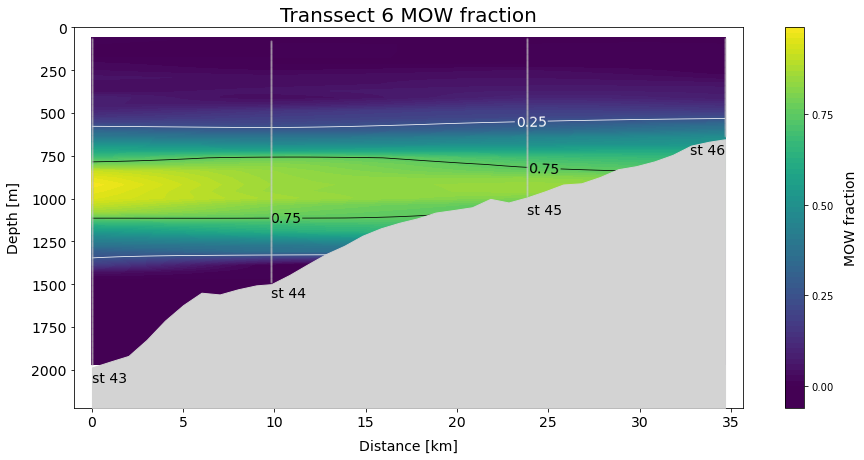

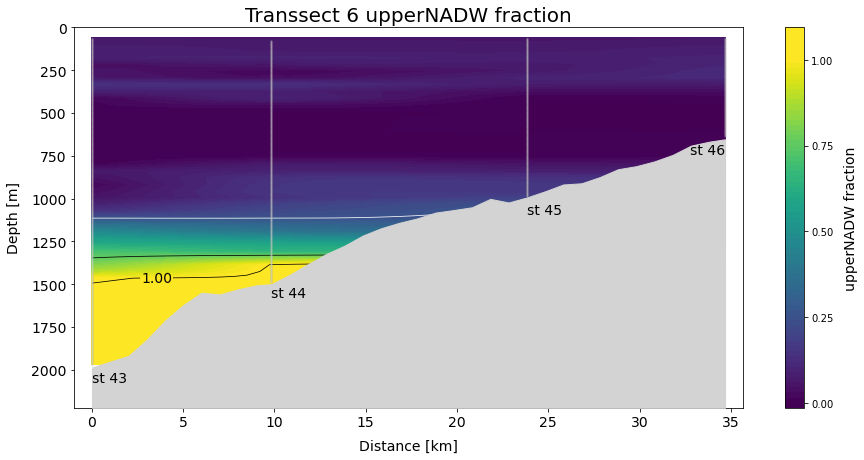

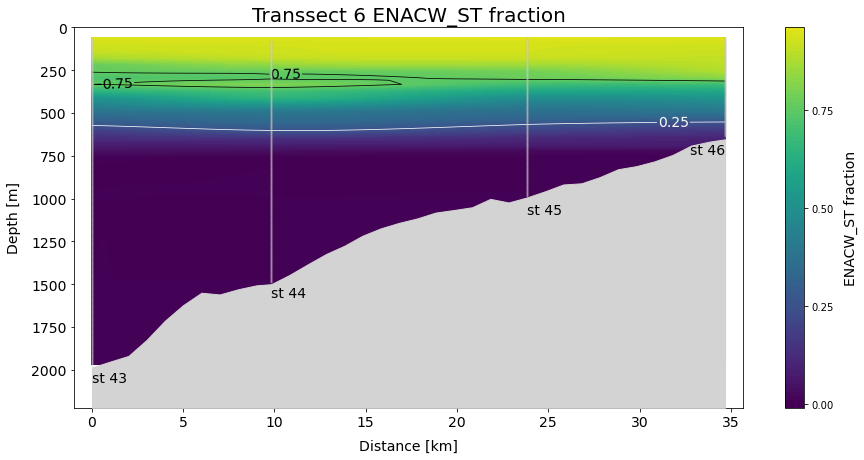

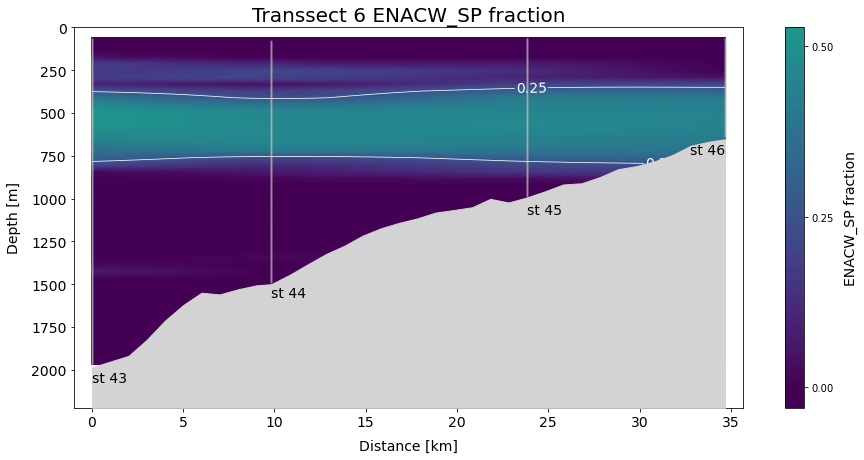

In [169]:
#path_fig = False

fontsize_label = 14
fontsize_title = 20
extension = '.png'

xoffset = 1

n_dep = ompa_transsect['depth'].max()
maxdist = dataset_transsects[t]['distances'].max()/1000

#Plotting features
#watermass = 'MOW'
cmap = 'viridis'
interpolation = 'linear'    #other options are 'cubic', 'linear', 'nearest'

for watermass in wm:

    #Plotting
    fig, ax0 = plt.subplots(1,1, figsize = (15,7))

    #Axis limits
    ax0.set_xlim(0-xoffset, maxdist+xoffset)
    ax0.set_ylim(n_dep+250, 0)
    ax0.margins(0.05)
    
    #Plot the bathymetry
    if lowres_bath == True:
        plt.fill_between(list(dict.fromkeys(dataset_transsects[t]['distances']/1000)), bath, n_dep+250, 
                            color='lightgray', zorder=50)
    else:
        plt.fill_between(transsects_bath[t]['distance']/1000, transsects_bath[t]['bathymetry']*-1, n_dep+250, 
                            color='lightgray', zorder=100)
    #Levels to contour (int->nº of levels to contour / list-> values to contour)
    #levels = [35.9, 36.3]
    
    #levels = [0, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    levels = np.arange(0,1.1,0.1)
    
    clevels = [0.25, 0.75, 1]

    #GRID
    if lowres_bath == True:
        points = list(zip(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth']))
        xi, yi = np.mgrid[0:maxdist:100j, depth_range_upper:n_dep:100j]
        grid_ztest = griddata(points, ompa_transsect[watermass], (xi, yi), method=interpolation, rescale=True )
        handle1 = ax0.pcolormesh(xi, yi, grid_ztest, norm=PiecewiseNorm(levels), cmap=cmap, shading='auto')
        CS = ax0.contour(xi, yi, grid_ztest, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)
    else:
        interp = scipy.interpolate.Rbf(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], ompa_transsect[watermass], function=interpolation)
        xi, yi = np.mgrid[0:maxdist:50j, depth_range_upper:n_dep:50j]
        zi = interp(xi, yi)
        handle1 = ax0.contourf(xi, yi, zi, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
        CS = ax0.contour(xi, yi, zi, colors=['white','k','k','k'], linewidths=0.75, levels=clevels)

    #GRID COLOURING
    #vmin, vmax = 3, 15
    #handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
    #handle1 = ax0.contourf(xi, yi, grid_ztest, cmap=cmap, norm=PiecewiseNorm(levels), levels=100)
    

    #Ploting the CTD stations cast
    b = ax0.scatter(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], alpha=0.06, c='lightgrey', s=2, zorder=120)
    
    #Contours
    ax0.clabel(CS, CS.levels, inline=True, fmt='%1.2f', fontsize=fontsize_label)

    #Colorbar
    cb = fig.colorbar(handle1, ax=ax0, ticks=np.arange(0,1.2,0.25))
    
    #Titles
    #plt.title('Transsect '+transsect[-1]+' - '+variable[0].upper()+variable[1:], fontsize=fontsize_title)
    plt.title('Transsect '+t[-1]+' '+watermass+' fraction', fontsize=fontsize_title)
    plt.xlabel('Distance [km]',  fontsize=fontsize_label, labelpad=10)
    plt.ylabel('Depth [m]', fontsize=fontsize_label, labelpad=10)
    cb.set_label(label= watermass+' fraction', fontsize=fontsize_label, labelpad=10)

    #Label the stations
    for i in range(len(transsects[t])):
        ncast = list(transsects[t])[i]   
        x = distances[t][i]/1000
        y = len(data[ncast].index)+100
        if ncast == list(transsects[t])[-1]:
            ha = 'right'
        else:
            ha ='left'
        if lowres_bath == False:
            plt.text(x,y,s='st '+ncast, fontsize=fontsize_label, ha=ha, va='top', zorder=100)
            
    plt.xticks(fontsize=fontsize_label)
    plt.yticks(fontsize=fontsize_label)
    ax0.set_yticks(np.arange(0,2200,200))
    ax0.set_yticks(np.arange(0,2200,100), minor=True)
    
    name = 'test'+str(test)+'_'+watermass+'_'+t
    if path_fig != False:
        if lowres_bath == True:
            plt.savefig(path_fig+watermass+'/'+name+'_lowresbath'+extension, dpi=300) 
        else:
            plt.savefig(path_fig+watermass+'/'+name+extension, dpi=300)
            
    plt.show()

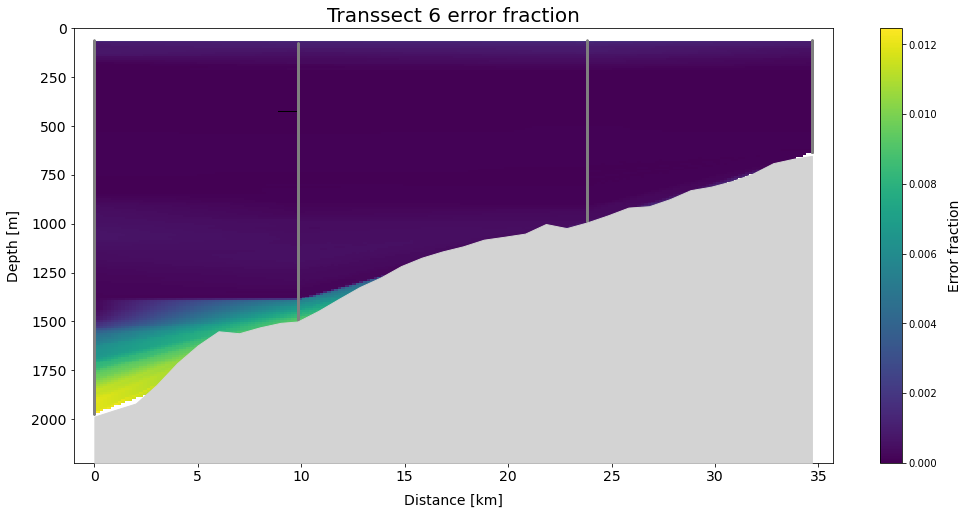

In [170]:
extension = '.png'

#Plotting
fig, ax0 = plt.subplots(1,1, figsize = (17,8))

#Axis limits
ax0.set_xlim(0-xoffset, maxdist+xoffset)
ax0.set_ylim(n_dep+250, 0)
ax0.margins(0.05)

#Plot the bathymetry
if lowres_bath == True:
    plt.fill_between(list(dict.fromkeys(dataset_transsects[t]['distances']/1000)), bath, n_dep+250, 
                        color='lightgray', zorder=50)
else:
    plt.fill_between(transsects_bath[t]['distance']/1000, transsects_bath[t]['bathymetry']*-1, n_dep+250, 
                        color='lightgray', zorder=100)

#Levels to contour (int->nº of levels to contour / list-> values to contour)
#levels = [35.9, 36.3]
levels = [1]

#GRID
points = list(zip(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth']))
xi, yi = np.mgrid[0:maxdist:200j, 0:n_dep:200j]
grid_ztest = griddata(points, ompa_transsect['error'], (xi, yi), method=interpolation, rescale=True )

#GRID COLOURING
#vmin, vmax = 3, 15
#handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')

#Ploting the CTD stations cast
b = ax0.scatter(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], c='grey', s=2)

#Contours
CS = ax0.contour(xi, yi, grid_ztest, colors=['k','white'], linewidths=0.75, levels=levels)
ax0.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=fontsize_label)

#Colorbar
cb = fig.colorbar(handle1, ax=ax0)

#Titles
#plt.title('Transsect '+transsect[-1]+' - '+variable[0].upper()+variable[1:], fontsize=fontsize_title)
plt.title('Transsect '+t[-1]+' error fraction', fontsize=fontsize_title)
plt.xlabel('Distance [km]',  fontsize=fontsize_label, labelpad=10)
plt.ylabel('Depth [m]', fontsize=fontsize_label, labelpad=10)
cb.set_label(label= 'Error fraction', fontsize=fontsize_label, labelpad=10)

#Label the stations
for i in range(len(transsects[t])):
    ncast = list(transsects[t])[i]   
    x = distances[t][i]/1000
    y = len(data[ncast].index)+20
    if ncast == list(transsects[t])[-1]:
        ha = 'right'
    else:
        ha ='left'
    #plt.text(x,y,s='st '+ncast, fontsize=fontsize_label, ha=ha, va='top', zorder=100)

plt.xticks(fontsize=fontsize_label)
plt.yticks(fontsize=fontsize_label)

name = 'test'+str(test)+'_error_'+t
if path_fig != False:
    if lowres_bath == True:
        plt.savefig(path_fig+name+'_lowresbath'+extension, dpi=300) 
    else:
        plt.savefig(path_fig+name+extension, dpi=300)

plt.show()

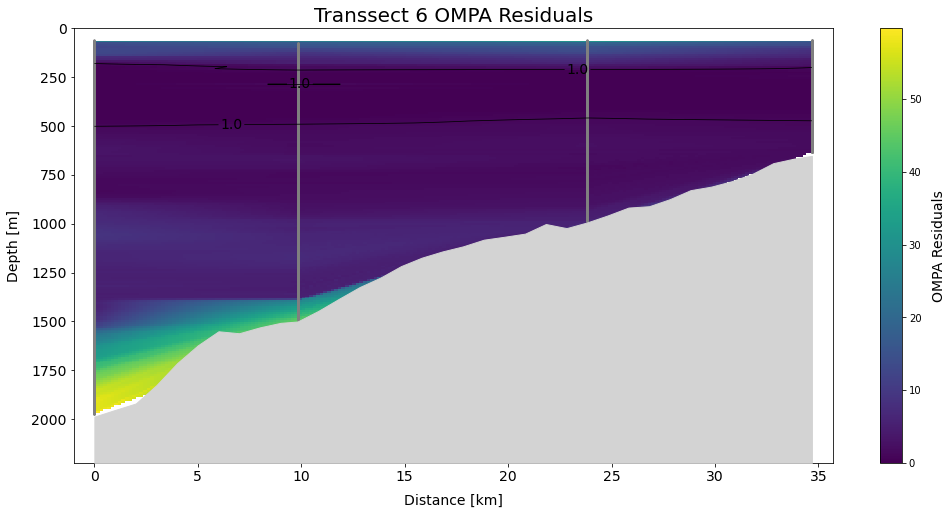

In [171]:
extension = '.png'

#Plotting
fig, ax0 = plt.subplots(1,1, figsize = (17,8))

#Axis limits
ax0.set_xlim(0-xoffset, maxdist+xoffset)
ax0.set_ylim(n_dep+250, 0)
ax0.margins(0.05)

#Plot the bathymetry
if lowres_bath == True:
    plt.fill_between(list(dict.fromkeys(dataset_transsects[t]['distances']/1000)), bath, n_dep+250, 
                        color='lightgray', zorder=50)
else:
    plt.fill_between(transsects_bath[t]['distance']/1000, transsects_bath[t]['bathymetry']*-1, n_dep+250, 
                        color='lightgray', zorder=100)

#Levels to contour (int->nº of levels to contour / list-> values to contour)
#levels = [35.9, 36.3]
levels = [1]

#GRID
points = list(zip(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth']))
xi, yi = np.mgrid[0:maxdist:200j, 0:n_dep:200j]
grid_ztest = griddata(points, ompa_transsect['residual'], (xi, yi), method=interpolation, rescale=True )

#GRID COLOURING
#vmin, vmax = 3, 15
#handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
handle1 = ax0.pcolormesh(xi, yi, grid_ztest, cmap=cmap, shading='auto')

#Ploting the CTD stations cast
b = ax0.scatter(dataset_transsects[t]['distances']/1000, dataset_transsects[t]['depth'], c='grey', s=2)

#Contours
CS = ax0.contour(xi, yi, grid_ztest, colors=['k','white'], linewidths=0.75, levels=levels)
ax0.clabel(CS, CS.levels, inline=True, fmt='%1.1f', fontsize=fontsize_label)

#Colorbar
cb = fig.colorbar(handle1, ax=ax0)

#Titles
#plt.title('Transsect '+transsect[-1]+' - '+variable[0].upper()+variable[1:], fontsize=fontsize_title)
plt.title('Transsect '+t[-1]+' OMPA Residuals', fontsize=fontsize_title)
plt.xlabel('Distance [km]',  fontsize=fontsize_label, labelpad=10)
plt.ylabel('Depth [m]', fontsize=fontsize_label, labelpad=10)
cb.set_label(label= 'OMPA Residuals', fontsize=fontsize_label, labelpad=10)

#Label the stations
for i in range(len(transsects[t])):
    ncast = list(transsects[t])[i]   
    x = distances[t][i]/1000
    y = len(data[ncast].index)+20
    if ncast == list(transsects[t])[-1]:
        ha = 'right'
    else:
        ha ='left'
    #plt.text(x,y,s='st '+ncast, fontsize=fontsize_label, ha=ha, va='top', zorder=100)

plt.xticks(fontsize=fontsize_label)
plt.yticks(fontsize=fontsize_label)

name = 'test'+str(test)+'_residual_'+t
if path_fig != False:
    if lowres_bath == True:
        plt.savefig(path_fig+name+'_lowresbath'+extension, dpi=300) 
    else:
        plt.savefig(path_fig+name+extension, dpi=300)

plt.show()